In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  !ls

Saving BBB_labels.txt to BBB_labels.txt
Saving BBB_features.csv to BBB_features.csv
User uploaded file "BBB_labels.txt" with length 6110 bytes
BBB_features.csv  BBB_labels.txt  sample_data
User uploaded file "BBB_features.csv" with length 3357142 bytes
BBB_features.csv  BBB_labels.txt  sample_data


In [2]:
import re
import numpy as np
import pandas as pd

df = pd.read_csv('BBB_features.csv', sep=';')
label = pd.read_csv('BBB_labels.txt', header=None, sep=' ')
newdf = pd.DataFrame(columns=df.columns)
logbb = []
permeate = []
for molname in df['Objects']:
    basename = re.sub(r'_c0', '', molname)
    if basename in label[0].values:
        lobBB = label[label[0] == basename][1].values[0]
        logbb.append(lobBB)
        if lobBB > 0:
            permeate.append(1)
        else:
            permeate.append(0)
        newdf = pd.concat([newdf, df[df['Objects'] == molname]])
    else:
        print('removing', molname)

df = newdf

<ipython-input-2-f75cd362ee4d>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, df[df['Objects'] == molname]])


removing 1,1,1,2-tetrachloroethane_c1
removing 1,1,1,2-tetrachloroethane_c2
removing 1,1,1,2-tetrachloroethane_c3
removing 1,1,1,2-tetrachloroethane_c4
removing 1,1,1,2-tetrachloroethane_c5
removing 1,1,1,2-tetrachloroethane_c6
removing 1,1,1,2-tetrachloroethane_c7
removing 1,1,1,2-tetrachloroethane_c8
removing 1,4-divinyloxybutane_c10
removing 1,4-divinyloxybutane_c11
removing 1,4-divinyloxybutane_c12
removing 1,4-divinyloxybutane_c13
removing 1,4-divinyloxybutane_c14
removing 1,4-divinyloxybutane_c15
removing 1,4-divinyloxybutane_c1
removing 1,4-divinyloxybutane_c2
removing 1,4-divinyloxybutane_c3
removing 1,4-divinyloxybutane_c4
removing 1,4-divinyloxybutane_c5
removing 1,4-divinyloxybutane_c6
removing 1,4-divinyloxybutane_c7
removing 1,4-divinyloxybutane_c8
removing 1,4-divinyloxybutane_c9
removing 1-butanol_c10
removing 1-butanol_c11
removing 1-butanol_c12
removing 1-butanol_c13
removing 1-butanol_c14
removing 1-butanol_c15
removing 1-butanol_c16
removing 1-butanol_c17
removing 1-

In [3]:
print('logBB', len(logbb))
print('permeate', len(permeate))
print(df.shape)

logBB 330
permeate 330
(330, 128)


In [4]:
X = df.drop(['Objects'], axis=1)
X = X.dropna(axis=1)
# remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]
# remove duplicate columns
X = X.T.drop_duplicates().T
y_regression = np.array(logbb)
y_classification = np.array(permeate)

print('X.shape', X.shape)
print('y_regression.shape', y_regression.shape)
print('y_classification.shape', y_classification.shape)

X.shape (330, 120)
y_regression.shape (330,)
y_classification.shape (330,)


In [5]:
# remove the highly correalted features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(X[to_drop], axis=1)
print('to_drop', to_drop)
print('X.shape after removing highly correlated features', X.shape)

to_drop ['S', 'G', 'W3', 'W4', 'W5', 'D2', 'D4', 'D5', 'D6', 'D7', 'D8', 'WO2', 'WO3', 'WN1', 'WN2', 'WN3', 'WN4', 'WN5', 'CW2', 'CW3', 'CW4', 'CD6', 'CD7', 'CD8', 'POL', 'MW', 'DIFF', 'HSA', 'PHSAR', 'LgD6', 'LgD7', 'LgD7.5', 'LgD8', 'LgD9', 'LgD10', '%FU5', '%FU6', '%FU7', 'LgS4', 'LgS5', 'LgS6', 'LgS7', 'LgS7.5', 'LgS8', 'LgS9', 'LgS10', 'LgS11', 'Spol/S']
X.shape after removing highly correlated features (330, 72)


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_regression_train, \
    y_regression_test, y_classification_train, \
    y_classification_test = \
    train_test_split(X, y_regression, y_classification, \
                     test_size=0.2, random_state=42)
print('X_train.shape', X_train.shape)
print('y_regression_train.shape', y_regression_train.shape)
print('y_classification_train.shape', y_classification_train.shape)
print('X_test.shape', X_test.shape)
print('y_regression_test.shape', y_regression_test.shape)
print('y_classification_test.shape', y_classification_test.shape)

ntrees = 50

X_train.shape (264, 72)
y_regression_train.shape (264,)
y_classification_train.shape (264,)
X_test.shape (66, 72)
y_regression_test.shape (66,)
y_classification_test.shape (66,)


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standadize the data first
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# It then uses this learned information to transform the data by
# subtracting the mean and dividing by the standard deviation
# of each feature.
for ncomp in range(1, 20):
    pca = PCA(n_components=ncomp)
    X_pca = pca.fit_transform(X_train)
    totalexplained = sum(pca.explained_variance_ratio_)
    print('ncomp %3d'%(ncomp), 'totalexplained %3.2f'%(totalexplained))

ncomp   1 totalexplained 0.26
ncomp   2 totalexplained 0.44
ncomp   3 totalexplained 0.52
ncomp   4 totalexplained 0.59
ncomp   5 totalexplained 0.65
ncomp   6 totalexplained 0.69
ncomp   7 totalexplained 0.72
ncomp   8 totalexplained 0.75
ncomp   9 totalexplained 0.78
ncomp  10 totalexplained 0.80
ncomp  11 totalexplained 0.82
ncomp  12 totalexplained 0.84
ncomp  13 totalexplained 0.85
ncomp  14 totalexplained 0.87
ncomp  15 totalexplained 0.88
ncomp  16 totalexplained 0.89
ncomp  17 totalexplained 0.90
ncomp  18 totalexplained 0.91
ncomp  19 totalexplained 0.92


In [8]:
pca = PCA(n_components=18)
pca.fit(X_train)
X_train = pca.transform(X_train)
print('X_train.shape', X_train.shape)
X_test = pca.transform(X_test)
print('X_test.shape', X_test.shape)

X_train.shape (264, 18)
X_test.shape (66, 18)


In [9]:
import timeit

start = timeit.default_timer()
rf_regression = RandomForestRegressor(n_estimators=ntrees, random_state=42)
rf_regression.fit(X_train, y_regression_train)
y_regression_pred = rf_regression.predict(X_train)
msetrain = mean_squared_error(y_regression_train, y_regression_pred)
r2train = rf_regression.score(X_train, y_regression_train)
print('  Train R2 %5.3f'%(r2train))
print(' Train MSE %8.6e'%(msetrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

  Train R2 0.933
 Train MSE 3.005643e-02
Time train    0.298 s


In [10]:
msetest = mean_squared_error(y_regression_test, rf_regression.predict(X_test))
r2test = rf_regression.score(X_test, y_regression_test)
print('   Test R2 %5.3f'%(r2test))
print('  Test MSE %8.6e'%(msetest))

   Test R2 0.698
  Test MSE 1.873947e-01


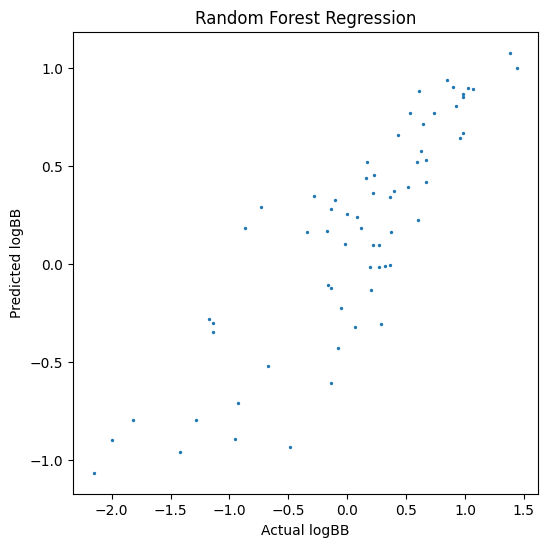

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_regression_test, rf_regression.predict(X_test), s=2)
#plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('Actual logBB')
plt.ylabel('Predicted logBB')
plt.title('Random Forest Regression')
plt.show()

In [12]:
# build a calssification RandomForrest model
start = timeit.default_timer()
rf_classification = RandomForestClassifier(n_estimators=ntrees, random_state=42)
rf_classification.fit(X_train, y_classification_train)
y_classification_pred = rf_classification.predict(X_train)
accuracytrain = accuracy_score(y_classification_train, y_classification_pred)
print('Train Accuracy %5.3f'%(accuracytrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

Train Accuracy 1.000
Time train    0.117 s


In [13]:
from sklearn.metrics import confusion_matrix

testaccuracy = accuracy_score(y_classification_test, rf_classification.predict(X_test))
print(' Test Accuracy %5.3f'%(testaccuracy))
# confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_classification_test, rf_classification.predict(X_test)))


 Test Accuracy 0.803
Confusion matrix
[[19  7]
 [ 6 34]]
